# OpenScope's Dendritic Coupling Dataset

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


from mpl_interactions import hyperslicer
from mpl_interactions import ipyplot as iplt

from scipy import interpolate
from scipy.stats import ttest_ind

### The Experiment

### Downloading Ophys File

In [3]:
dandiset_id = "000336"
# dandi_filepath = "sub-621602/sub-621602_ses-1194809891-acq-1194973904_ophys.nwb"
# dandi_filepath = "sub-621603/sub-621603_ses-1194683535-acq-1194752582_ophys.nwb"
dandi_filepath = "sub-621602/sub-621602_ses-1194555869-acq-1194754131_image+ophys.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [4]:
# This can sometimes take a while depending on the size of the file
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.59.0) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Imaging Data

In [5]:
nwb.lab_meta_data

{'metadata': metadata abc.OphysMetadata at 0x1322687346048
 Fields:
   experiment_container_id: 0
   field_of_view_height: 512
   field_of_view_width: 512
   imaging_depth: 351
   imaging_plane_group: 0
   imaging_plane_group_count: 4
   ophys_experiment_id: 1194754131
   ophys_session_id: 1194555869}

In [6]:
nwb.imaging_planes

{'imaging_plane_1': imaging_plane_1 pynwb.ophys.ImagingPlane at 0x1322687871392
 Fields:
   conversion: 1.0
   description: (512, 512) field of view in VISp at depth 351 um
   device: MESO.2 pynwb.device.Device at 0x1322687870288
 Fields:
   description: Allen Brain Observatory - Mesoscope 2P Rig
 
   excitation_lambda: 910.0
   imaging_rate: 11.0
   indicator: GCaMP6f
   location: VISp
   optical_channel: (
     channel_1 <class 'pynwb.ophys.OpticalChannel'>
   )
   unit: meters}

### Stimulus Templates

In [7]:
nwb.stimulus_template.keys()

dict_keys(['flower_fwd', 'flower_fwd_rev', 'flower_rev', 'flower_rev_fwd', 'touch_of_evil_fwd', 'touch_of_evil_fwd_rev', 'touch_of_evil_rev', 'touch_of_evil_rev_fwd', 'worms_fwd', 'worms_fwd_rev', 'worms_rev', 'worms_rev_fwd'])

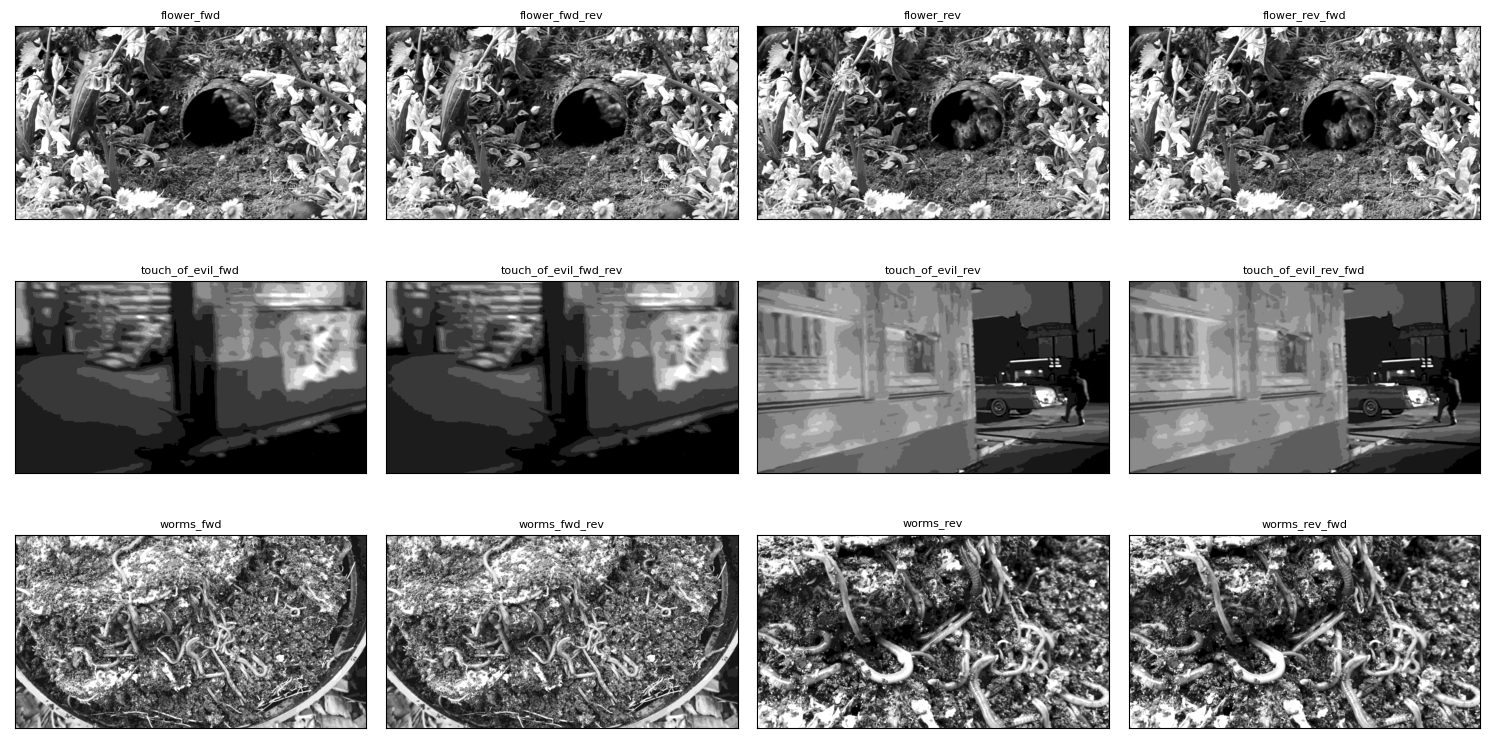

In [8]:
n_cols = 4
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,8))

for i, template_name in enumerate(nwb.stimulus_template.keys()):
    template_img = nwb.stimulus_template[template_name].data[0]

    ax_row = int(i / n_cols)
    ax_col = i % n_cols
    axes[ax_row][ax_col].imshow(template_img, cmap="gray")
    axes[ax_row][ax_col].set_title(template_name, fontsize=8)

for ax in axes.flat:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

fig.tight_layout()

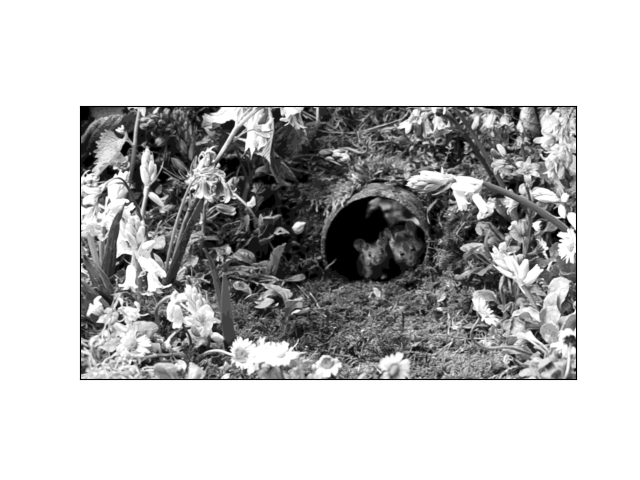

In [9]:
%matplotlib ipympl
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# change this key to view other stim template movies
template = nwb.stimulus_template["flower_rev_fwd"].data
view = hyperslicer(template, play_buttons=True, cmap="gray")

### Selecting Stimulus Times

In [10]:
nwb.intervals.keys()

dict_keys(['fixed_gabors_presentations', 'gratings_presentations', 'movie_flower_fwd_presentations', 'movie_flower_fwd_rev_presentations', 'movie_flower_rev_fwd_presentations', 'movie_flower_rev_presentations', 'movie_touch_of_evil_fwd_presentations', 'movie_touch_of_evil_fwd_rev_presentations', 'movie_touch_of_evil_rev_fwd_presentations', 'movie_touch_of_evil_rev_presentations', 'movie_worms_fwd_presentations', 'movie_worms_fwd_rev_presentations', 'movie_worms_rev_fwd_presentations', 'movie_worms_rev_presentations', 'rotate_gabors_presentations', 'spontaneous_presentations'])

In [11]:
stim_table = nwb.intervals["movie_worms_fwd_presentations"]
print(stim_table.colnames)
stim_table[:10]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'frame', 'color', 'contrast', 'opacity', 'ori', 'size', 'units', 'stimulus_index', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,frame,color,contrast,opacity,ori,size,units,stimulus_index,tags,timeseries
id,,,,,,,,,,,,,,
0,80.065970,80.099328,movie_worms_fwd,5.0,0.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,8.0,[stimulus_time_interval],"[(1628, 2, timestamps pynwb.base.TimeSeries at..."
1,80.099328,80.132686,movie_worms_fwd,5.0,1.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,8.0,[stimulus_time_interval],"[(1630, 2, timestamps pynwb.base.TimeSeries at..."
2,80.132686,80.166044,movie_worms_fwd,5.0,2.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,8.0,[stimulus_time_interval],"[(1632, 2, timestamps pynwb.base.TimeSeries at..."
3,80.166044,80.199402,movie_worms_fwd,5.0,3.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,8.0,[stimulus_time_interval],"[(1634, 2, timestamps pynwb.base.TimeSeries at..."
4,80.199402,80.232760,movie_worms_fwd,5.0,4.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,8.0,[stimulus_time_interval],"[(1636, 2, timestamps pynwb.base.TimeSeries at..."
5,80.232760,80.266118,movie_worms_fwd,5.0,5.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,8.0,[stimulus_time_interval],"[(1638, 2, timestamps pynwb.base.TimeSeries at..."
6,80.266118,80.299476,movie_worms_fwd,5.0,6.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,8.0,[stimulus_time_interval],"[(1640, 2, timestamps pynwb.base.TimeSeries at..."
7,80.299476,80.332834,movie_worms_fwd,5.0,7.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,8.0,[stimulus_time_interval],"[(1642, 2, timestamps pynwb.base.TimeSeries at..."
8,80.332834,80.366191,movie_worms_fwd,5.0,8.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,8.0,[stimulus_time_interval],"[(1644, 2, timestamps pynwb.base.TimeSeries at..."


In [12]:
print(np.mean(np.diff(stim_table.start_time)))
print(set(stim_table.frame))

0.4224204045288495
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0

In [13]:
# flower video reverses around frame 190
rev_stim_select = lambda row: row.frame.item() == 190
rev_stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if rev_stim_select(stim_table[i])]
print(len(rev_stim_times))

15


### Extracting ROI Fluorescence

In [14]:
dff = nwb.processing["ophys"]["dff"]
dff_trace = dff.roi_response_series["traces"].data
dff_timestamps = dff.roi_response_series["traces"].timestamps

# accessing the above data may look different for older nwb files, like the following
# dff_trace = dff.roi_response_series["RoiResponseSeries"].data
# dff_timestamps = dff.roi_response_series["RoiResponseSeries"].timestamps

print(dff_trace.shape)
print(dff_timestamps.shape)

avg_dff_trace = np.average(dff_trace, axis=1)

(44184, 83)
(44184,)


### Session Timeline

In [15]:
# extract epoch times from stim table where stimulus rows have a different 'block' than following row
# returns list of epochs, where an epoch is of the form (stimulus name, stimulus block, start time, stop time)
def extract_epochs(stim_name, stim_table, epochs):
    
    # specify a current epoch stop and start time
    epoch_start = stim_table.start_time[0]
    epoch_stop = stim_table.stop_time[0]

    # for each row, try to extend current epoch stop_time
    for i in range(len(stim_table)):
        this_block = stim_table.stimulus_block[i]
        # if end of table, end the current epoch
        if i+1 >= len(stim_table):
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            break
            
        next_block = stim_table.stimulus_block[i+1]
        # if next row is the same stim block, push back epoch_stop time
        if next_block == this_block:
            epoch_stop = stim_table.stop_time[i+1]
        # otherwise, end the current epoch, start new epoch
        else:
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            epoch_start = stim_table.start_time[i+1]
            epoch_stop = stim_table.stop_time[i+1]
    
    return epochs

In [16]:
# extract epochs from all valid stimulus tables
epochs = []
for stim_name in nwb.intervals.keys():
    stim_table = nwb.intervals[stim_name]
    try:
        epochs = extract_epochs(stim_name, stim_table, epochs)
    except:
        continue

# epochs take the form (stimulus name, stimulus block, start time, stop time)
print(len(epochs))
epochs.sort(key=lambda x: x[2])
for epoch in epochs:
    print(epoch)

185
('movie_flower_fwd_presentations', 0.0, 30.024629999999995, 39.03206821101215)
('movie_touch_of_evil_fwd_presentations', 1.0, 40.03292, 49.04024821101215)
('movie_touch_of_evil_rev_fwd_presentations', 2.0, 50.04113, 59.04852821101215)
('movie_worms_fwd_rev_presentations', 3.0, 60.04941, 69.05676821101214)
('movie_worms_rev_fwd_presentations', 4.0, 70.05757999999999, 79.06505821101216)
('movie_worms_fwd_presentations', 5.0, 80.06596999999998, 89.07328821101216)
('movie_touch_of_evil_fwd_rev_presentations', 6.0, 90.0741, 99.08156821101214)
('movie_flower_fwd_rev_presentations', 7.0, 100.08244999999998, 109.08980821101214)
('movie_flower_rev_presentations', 8.0, 110.09063, 119.09807821101217)
('movie_flower_rev_fwd_presentations', 9.0, 120.09895, 129.10632821101217)
('movie_worms_rev_presentations', 10.0, 130.10714000000002, 139.11459821101215)
('movie_touch_of_evil_rev_presentations', 11.0, 140.11548000000002, 149.12283821101215)
('movie_worms_fwd_rev_presentations', 12.0, 150.12367,

In [17]:
# can set these manually to get a closer look at the timeline
time_start = min(epochs, key=lambda epoch: epoch[1])[1]
time_end = max(epochs, key=lambda epoch:epoch[2])[2]
# time_start = 3000
# time_end = 3100

# can set this to change what trace is displayed alongside epochs
display_trace = avg_dff_trace * 100 # to yield percentage
# unit_idx = 30
# display_trace = dff_trace[:,unit_idx] * 100

0.1940623410438961


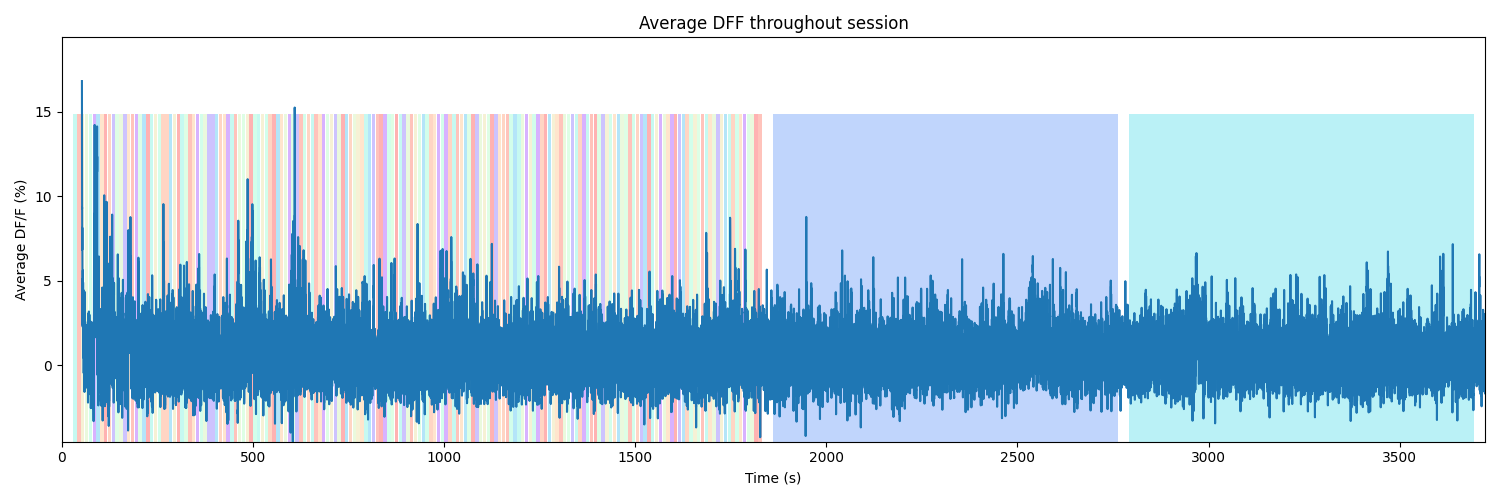

In [18]:
### make plot of chosen fluorescence trace over time with colored epoch sections

fig, ax = plt.subplots(figsize=(15,5))

# filter epochs which aren't at least partially in the time window
bounded_epochs = {epoch for epoch in epochs if epoch[2] < time_end and epoch[3] > time_start}

# assign unique color to each stimulus name
stim_names = list({epoch[0] for epoch in bounded_epochs})
colors = plt.cm.rainbow(np.linspace(0,1,len(stim_names)))
stim_color_map = {stim_names[i]:colors[i] for i in range(len(stim_names))}

epoch_key = {}
y_hi = np.amax(display_trace) # change these to manually set height of the plot
y_lo = np.amin(display_trace)
# draw colored rectangles for each epoch
for epoch in bounded_epochs:
    stim_name, stim_block, epoch_start, epoch_end = epoch
    color = stim_color_map[stim_name]
    rec = ax.add_patch(mpl.patches.Rectangle((epoch_start, y_lo), epoch_end-epoch_start, y_hi, alpha=0.3, facecolor=color))
    epoch_key[(stim_name)] = rec

ax.set_xlim(time_start, time_end)
ax.set_ylim(y_lo, y_hi)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Average DF/F (%)")
ax.set_title("Average DFF throughout session")

fig.legend(epoch_key.values(), epoch_key.keys(), loc="lower right", bbox_to_anchor=(1.25, 0.25))
ax.plot(dff_timestamps[:], display_trace)

print(np.amax(avg_dff_trace))
plt.tight_layout()
plt.show()

### Viewing Behavioral Data

In [19]:
eye_tracking = nwb.acquisition["EyeTracking"]
eye_tracking

EyeTracking abc.EllipseEyeTracking at 0x1322687872304
Fields:
  corneal_reflection_tracking: corneal_reflection_tracking abc.EllipseSeries at 0x1322678714816
Fields:
  angle: <HDF5 dataset "angle": shape (242895,), type "<f8">
  area: <HDF5 dataset "area": shape (242895,), type "<f8">
  area_raw: <HDF5 dataset "area_raw": shape (242895,), type "<f8">
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (242895, 2), type "<f8">
  description: no description
  height: <HDF5 dataset "height": shape (242895,), type "<f8">
  interval: 1
  offset: 0.0
  reference_frame: nose
  resolution: -1.0
  timestamps: eye_tracking abc.EllipseSeries at 0x1322678718080
Fields:
  angle: <HDF5 dataset "angle": shape (242895,), type "<f8">
  area: <HDF5 dataset "area": shape (242895,), type "<f8">
  area_raw: <HDF5 dataset "area_raw": shape (242895,), type "<f8">
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (242895, 2), type "<f8">
  description: no description
  height: <HDF5 dataset "height": shape (242895,), type "<f8">
  interval: 1
  offset: 0.0
  reference_frame: nose
  resolution: -1.0
  timestamp_link: (
    pupil_tracking <class 'abc.EllipseSeries'>,
    corneal_reflection_tracking <class 'abc.EllipseSeries'>,
    likely_blink <class 'pynwb.base.TimeSeries'>
  )
  timestamps: <HDF5 dataset "timestamps": shape (242895,), type "<f8">
  timestamps_unit: seconds
  unit: meters
  width: <HDF5 dataset "width": shape (242895,), type "<f8">

  timestamps_unit: seconds
  unit: meters
  width: <HDF5 dataset "width": shape (242895,), type "<f8">

  eye_tracking: eye_tracking abc.EllipseSeries at 0x1322678718080
Fields:
  angle: <HDF5 dataset "angle": shape (242895,), type "<f8">
  area: <HDF5 dataset "area": shape (242895,), type "<f8">
  area_raw: <HDF5 dataset "area_raw": shape (242895,), type "<f8">
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (242895, 2), type "<f8">
  description: no description
  height: <HDF5 dataset "height": shape (242895,), type "<f8">
  interval: 1
  offset: 0.0
  reference_frame: nose
  resolution: -1.0
  timestamp_link: (
    pupil_tracking <class 'abc.EllipseSeries'>,
    corneal_reflection_tracking <class 'abc.EllipseSeries'>,
    likely_blink <class 'pynwb.base.TimeSeries'>
  )
  timestamps: <HDF5 dataset "timestamps": shape (242895,), type "<f8">
  timestamps_unit: seconds
  unit: meters
  width: <HDF5 dataset "width": shape (242895,), type "<f8">

  likely_blink: likely_blink pynwb.base.TimeSeries at 0x1322688899056
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (242895,), type "|b1">
  description: blinks
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: eye_tracking abc.EllipseSeries at 0x1322678718080
Fields:
  angle: <HDF5 dataset "angle": shape (242895,), type "<f8">
  area: <HDF5 dataset "area": shape (242895,), type "<f8">
  area_raw: <HDF5 dataset "area_raw": shape (242895,), type "<f8">
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (242895, 2), type "<f8">
  description: no description
  height: <HDF5 dataset "height": shape (242895,), type "<f8">
  interval: 1
  offset: 0.0
  reference_frame: nose
  resolution: -1.0
  timestamp_link: (
    pupil_tracking <class 'abc.EllipseSeries'>,
    corneal_reflection_tracking <class 'abc.EllipseSeries'>,
    likely_blink <class 'pynwb.base.TimeSeries'>
  )
  timestamps: <HDF5 dataset "timestamps": shape (242895,), type "<f8">
  timestamps_unit: seconds
  unit: meters
  width: <HDF5 dataset "width": shape (242895,), type "<f8">

  timestamps_unit: seconds
  unit: N/A

  pupil_tracking: pupil_tracking abc.EllipseSeries at 0x1322678620016
Fields:
  angle: <HDF5 dataset "angle": shape (242895,), type "<f8">
  area: <HDF5 dataset "area": shape (242895,), type "<f8">
  area_raw: <HDF5 dataset "area_raw": shape (242895,), type "<f8">
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": 

In [20]:
# extract coords from eye tracking array
xs = np.array([point[0] for point in eye_tracking.eye_tracking.data])
ys = np.array([point[1] for point in eye_tracking.eye_tracking.data])

start_idx = 0
end_idx = len(eye_tracking.eye_tracking.data)
print("Min X:", np.nanmin(xs), "Max X:", np.nanmax(xs))
print("Min Y:", np.nanmin(ys), "Max Y:", np.nanmax(ys))

Min X: 194.70100310306955 Max X: 585.4981877740412
Min Y: 133.8902402624167 Max Y: 280.6943959304114


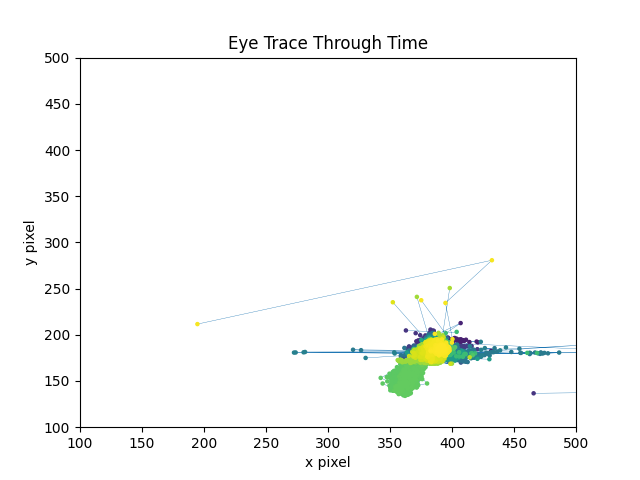

In [21]:
fig, ax = plt.subplots()
colors = plt.cm.viridis(np.linspace(0, 1, end_idx-start_idx))
ax.plot(xs[start_idx:end_idx], ys[start_idx:end_idx], zorder=0, linewidth=0.25)
ax.scatter(xs[start_idx:end_idx], ys[start_idx:end_idx], s=5, c=colors, zorder=1)

# change these to set the plot limits (there are sometimes unusual outliers)
ax.set_xlim(100,500)
ax.set_ylim(100,500)

ax.set_xlabel("x pixel")
ax.set_ylabel("y pixel")
ax.set_title("Eye Trace Through Time")
plt.show()

### Generating Response Windows

In [22]:
window_start_time = -2
window_end_time = 3
interp_hz = 10

In [23]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(dff_timestamps[0], dff_timestamps[-1], step=(1/interp_hz))
interp_dff = []

# interpolate channel by channel to save RAM
for channel in range(dff_trace.shape[1]):
    f = interpolate.interp1d(dff_timestamps, dff_trace[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_dff.append(f(time_axis))

interp_dff = np.array(interp_dff)

print(interp_dff.shape)

(83, 39415)


In [24]:
# validate window bounds
if window_start_time > 0:
    raise ValueError("start time must be non-positive number")
if window_end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
window_length = int((window_end_time-window_start_time) * interp_hz)

for stim_ts in rev_stim_times:
    # convert time to index
    start_idx = int( (stim_ts + window_start_time - dff_timestamps[0]) * interp_hz )
    end_idx = start_idx + window_length
 
    # bounds checking
    if start_idx < 0 or end_idx > interp_dff.shape[1]:
        continue
        
    windows.append(interp_dff[:,start_idx:end_idx])
    
if len(windows) == 0:
    raise ValueError("There are no windows for these timestamps")

windows = np.array(windows) * 100 # x100 to convert values to dF/F percentage
neuronwise_windows = np.swapaxes(windows,0,1)

print(neuronwise_windows.shape)

(83, 15, 50)


### Showing Response Windows

In [25]:
def show_dff_response(ax, dff, window_start_time, window_end_time, aspect="auto", vmin=None, vmax=None, yticklabels=[], skipticks=1, xlabel="Time (s)", ylabel="ROI", cbar=True, cbar_label=None):
    if len(dff) == 0:
        print("Input data has length 0; Nothing to display")
        return

    img = ax.imshow(dff, aspect=aspect, extent=[window_start_time, window_end_time, 0, len(dff)], vmin=vmin, vmax=vmax)
    if cbar:
        ax.colorbar(img, shrink=0.5, label=cbar_label)

    ax.plot([0,0],[0, len(dff)], ":", color="white", linewidth=1.0)

    if len(yticklabels) != 0:
        ax.set_yticks(range(len(yticklabels)))
        ax.set_yticklabels(yticklabels, fontsize=8)

        n_ticks = len(yticklabels[::skipticks])
        ax.yaxis.set_major_locator(plt.MaxNLocator(n_ticks))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [26]:
def show_many_responses(windows, rows, cols, window_idxs=None, title=None, subplot_title="", xlabel=None, ylabel=None, cbar_label=None, vmin=0, vmax=100):
    if window_idxs is None:
        window_idxs = range(len(windows))
    windows = windows[window_idxs]
    
    # handle case with no input data
    if len(windows) == 0:
        print("Input data has length 0; Nothing to display")
        return
    # handle cases when there aren't enough windows for number of rows
    if len(windows) < rows*cols:
        rows = (len(windows) // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(2*cols+2, 2*rows+2), layout="constrained")
    # handle case when there's only one row
    if len(axes.shape) == 1:
        axes = axes.reshape((1, axes.shape[0]))
    
    for i in range(rows*cols):
        ax_row = int(i // cols)
        ax_col = i % cols
        ax = axes[ax_row][ax_col]
        
        if i > len(windows)-1:
            ax.set_visible(False)
            continue

        window = windows[i]
        show_dff_response(ax, window, window_start_time, window_end_time, xlabel=xlabel, ylabel=ylabel, cbar=False, vmin=vmin, vmax=vmax)
        ax.set_title(f"{subplot_title} {window_idxs[i]}")
        if ax_row != rows-1:
            ax.get_xaxis().set_visible(False)
        if ax_col != 0:
            ax.get_yaxis().set_visible(False)

    fig.suptitle(title)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=axes, shrink=1.5/rows, label=cbar_label)

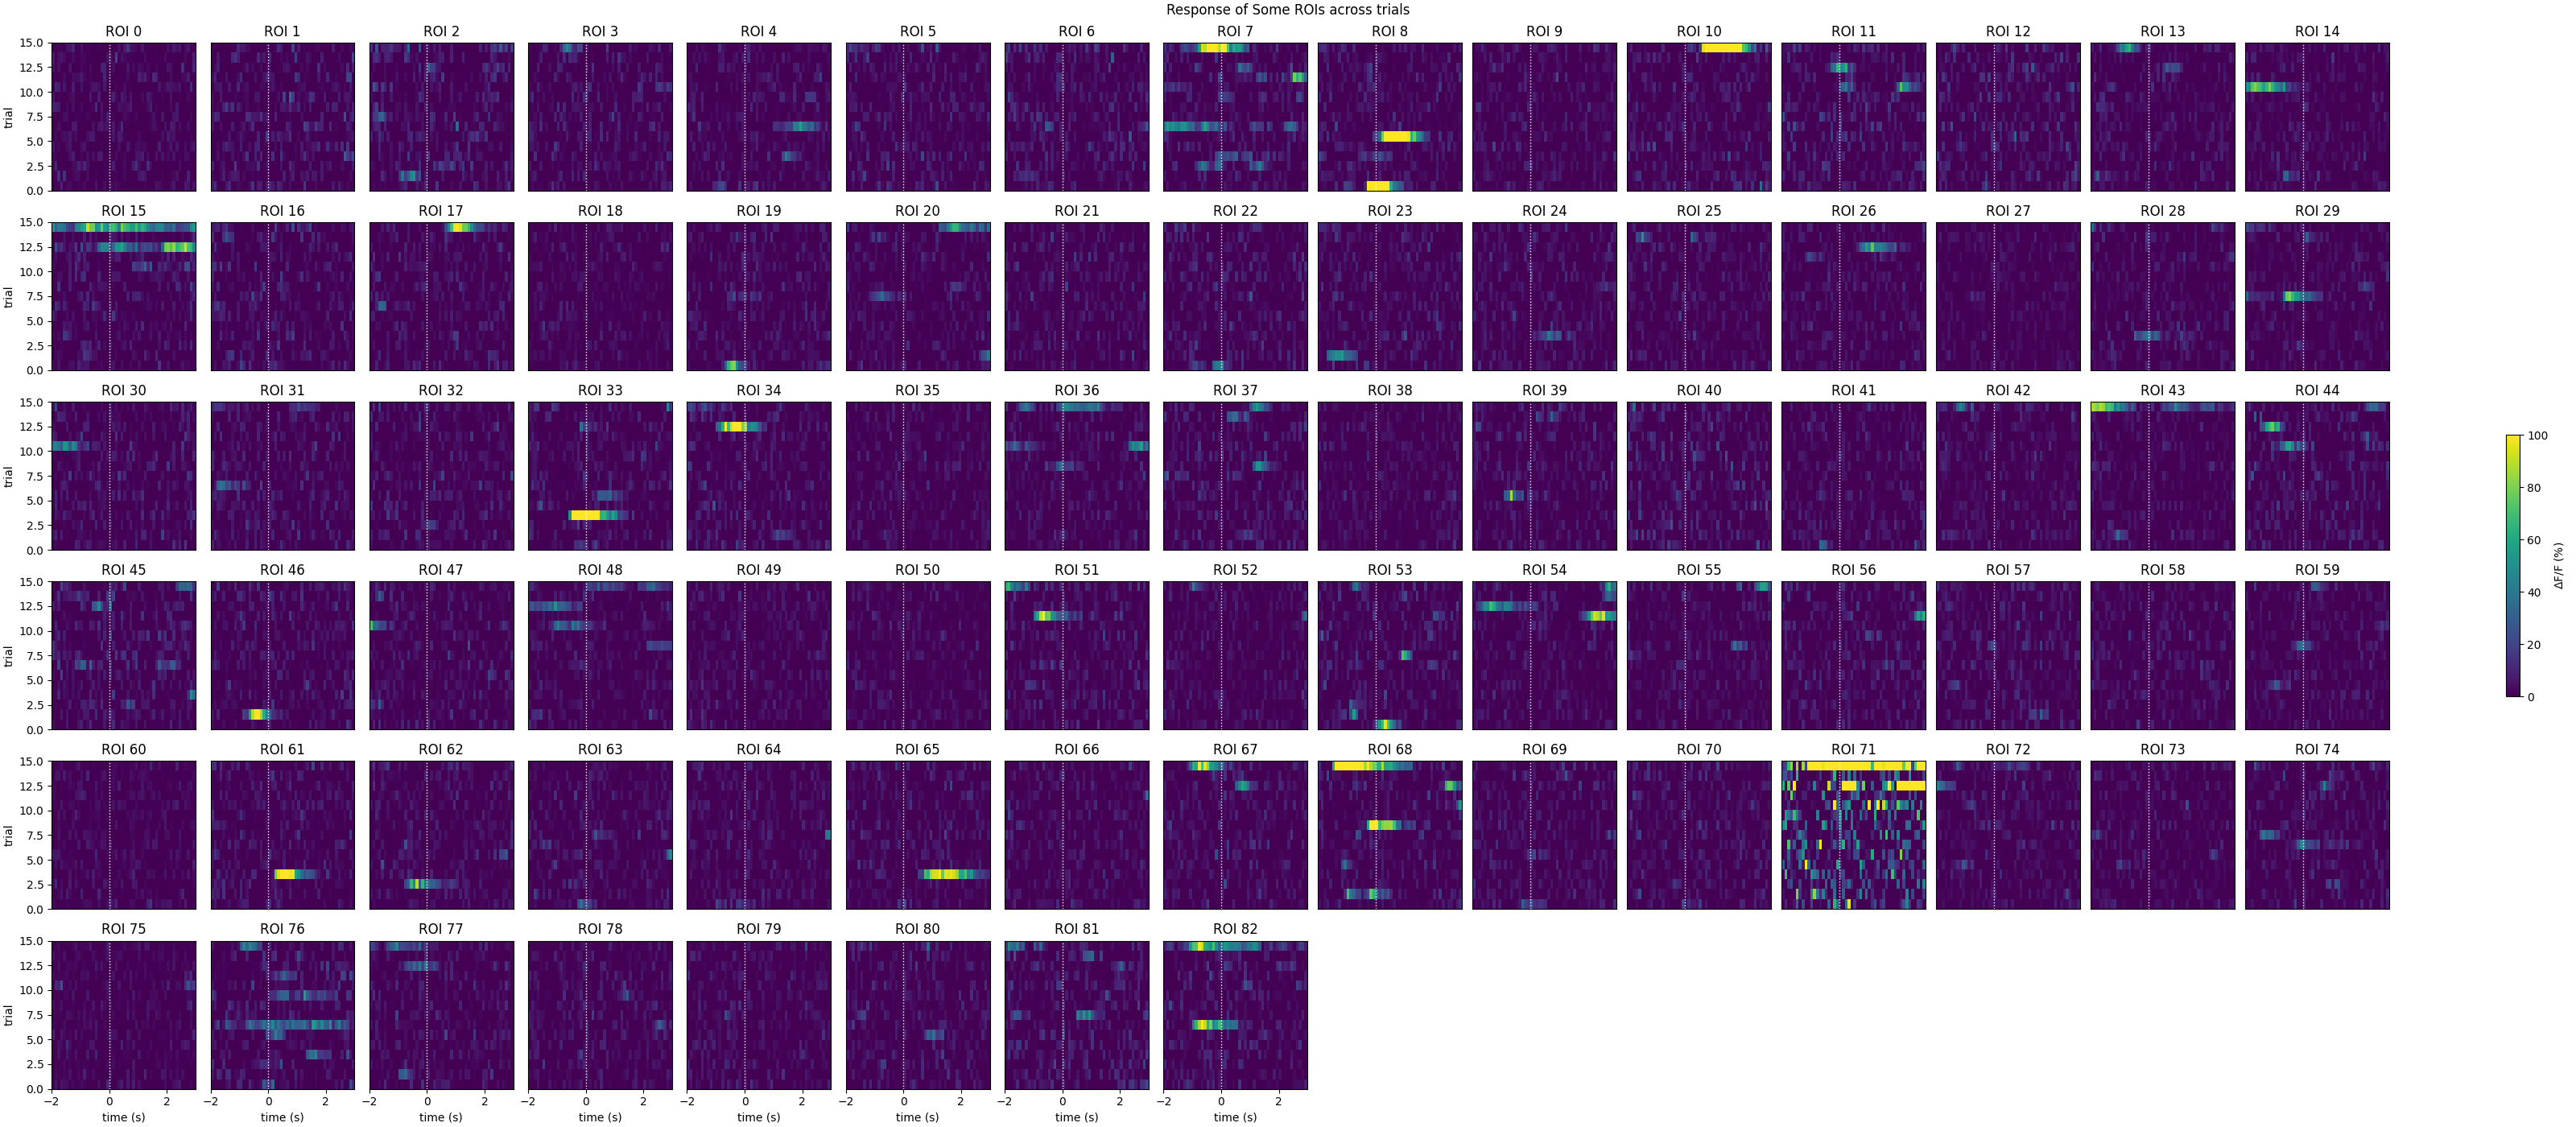

In [27]:
show_many_responses(neuronwise_windows,
                    6,
                    15,
                    title="Response of Some ROIs across trials",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")

### Selecting Cells

In [28]:
# get the index within the window that stimulus occurs (time 0)
stimulus_onset_idx = int(-window_start_time * interp_hz)
baseline = windows[:,:,0:stimulus_onset_idx]
evoked_responses = windows[:,:,stimulus_onset_idx:]

print(stimulus_onset_idx)
print(baseline.shape)
print(evoked_responses.shape)

20
(15, 83, 20)
(15, 83, 30)


In [29]:
mean_trial_responses = np.mean(evoked_responses, axis=2)
mean_trial_baselines = np.mean(baseline, axis=2)

n = mean_trial_responses.shape[0]
t,p = ttest_ind(mean_trial_responses, mean_trial_baselines)
IC3_selected_rois = np.where(p < 0.05 / n)[0]
print(f"Selected ROIs {IC3_selected_rois}")

Selected ROIs [79]


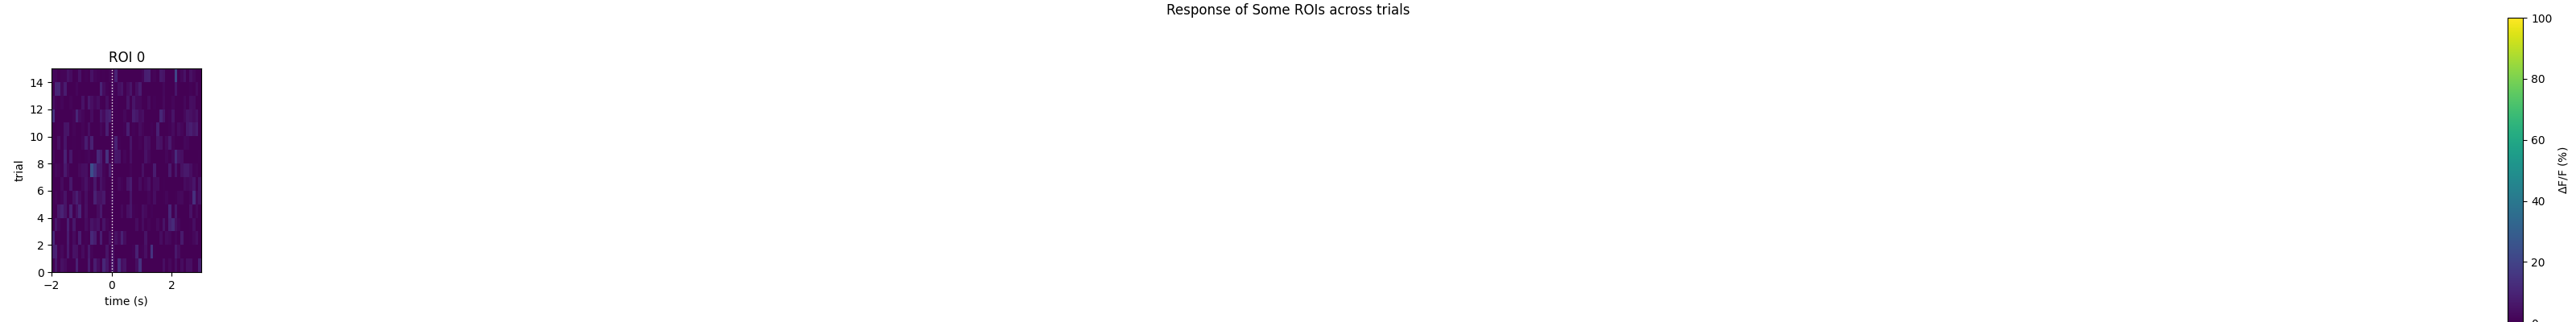

In [30]:
show_many_responses(neuronwise_windows[IC3_selected_rois],
                    6,
                    15,
                    title="Response of Some ROIs across trials",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")

In [31]:
# compare raw and denoised
# show template movies, playback